In [50]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [51]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [52]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

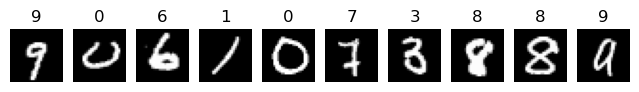

In [53]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

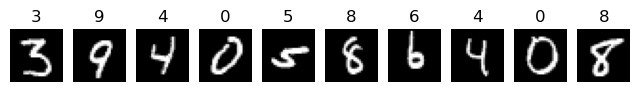

In [54]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

# Define dataloaders


In [55]:

training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)

# Define Linear_Variance_Scheduler


In [56]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Forward process output


In [57]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [58]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

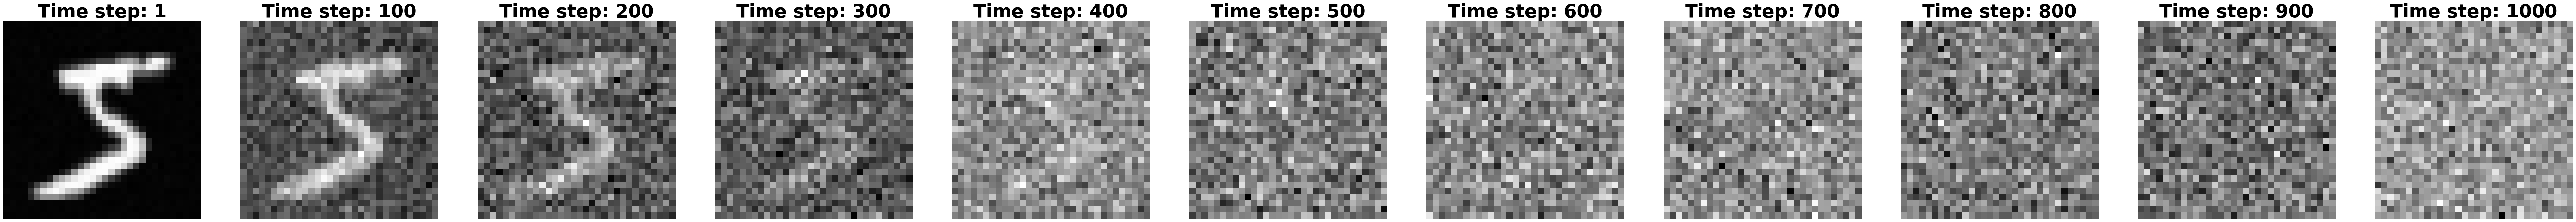

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False)

### Play with forward parameters

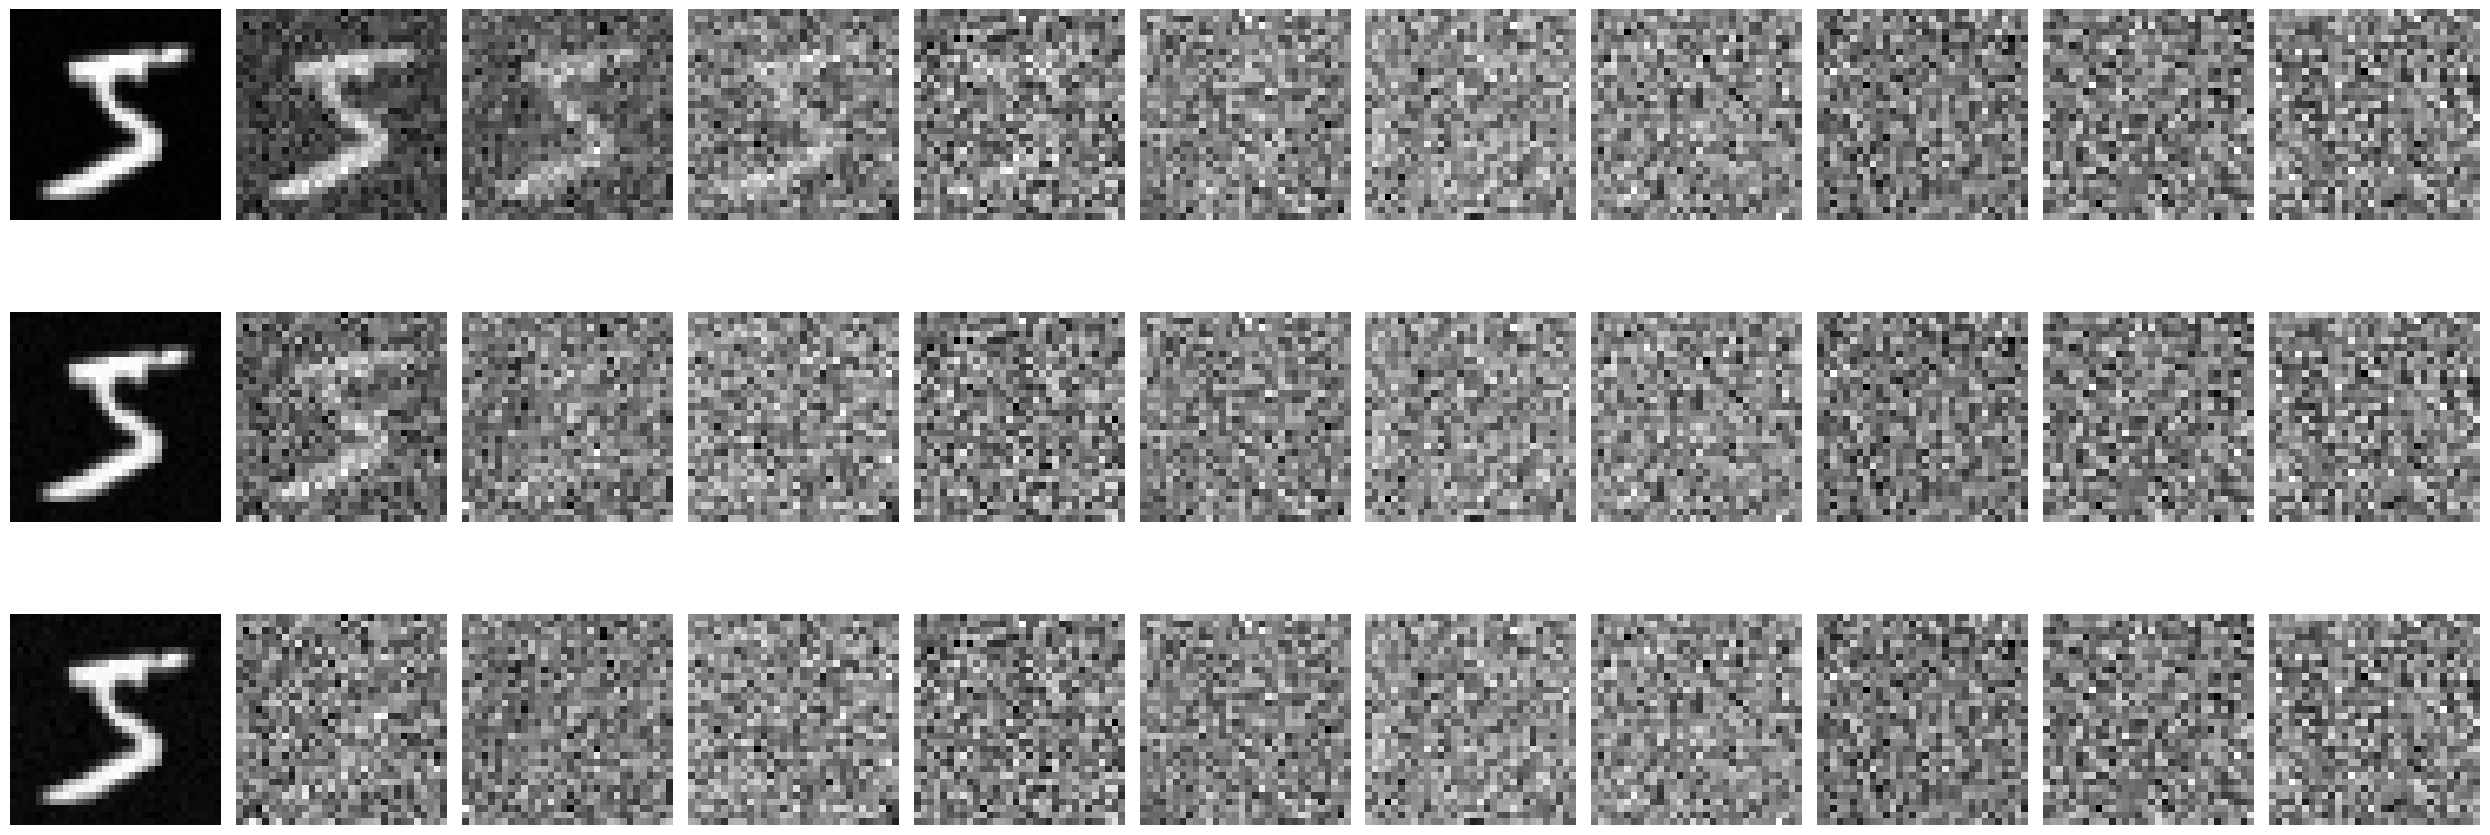

In [60]:
params_list = [
    {'time_steps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02},
    {'time_steps': 500, 'beta_start': 0.0005, 'beta_end': 0.05},
    {'time_steps': 200, 'beta_start': 0.001, 'beta_end': 0.1},
]

# Prepare data
get_img = training_dataset[0][0]
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# Generate noisy images for different parameter settings
fig, axes = plt.subplots(nrows=len(params_list), ncols=11, figsize=(25, 10))

for i, params in enumerate(params_list):
    scheduler = Linear_Variance_Scheduler(time_steps=params['time_steps'],
                                          beta_start=params['beta_start'],
                                          beta_end=params['beta_end'],
                                          device='cpu')
    noisy_img_stack = scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)
    
    for idx, img in enumerate(noisy_img_stack):
        axes[i, idx].imshow(img.squeeze(), cmap='gray')
        if idx == 0:
            axes[i, idx].set_ylabel(f"Steps: {params['time_steps']}\nBeta: [{params['beta_start']}, {params['beta_end']}]")
        axes[i, idx].axis(False)

plt.tight_layout()
plt.show()

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [61]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [62]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [63]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [64]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [ ]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [ ]:
from torchinfo import summary

summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ResBlock: 1, Sequential: 2, Conv2d: 3, GroupNorm: 3, SiLU: 3, Conv2d: 3, GroupNorm: 3, Sequential: 2, MaxPool2d: 3, ResBlock: 3, Sequential: 4, Conv2d: 5, GroupNorm: 5, SiLU: 5, Conv2d: 5, GroupNorm: 5, ResBlock: 3, Sequential: 4, Conv2d: 5, GroupNorm: 5, SiLU: 5, Conv2d: 5, GroupNorm: 5, SiLU: 3]

# SET-UP

In [ ]:
ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = UNet(t_emb_dim=256).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# TRAINING

In [ ]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 2
training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses.append(tst_batch_loss.item())
        test_per_epoch_loss = np.array(test_losses).mean()
        
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 156/156 [00:05<00:00, 29.16it/s]


Epoch: 1/2	| Training loss: 0.0629 |   Test loss: 0.0318


100%|██████████| 156/156 [00:05<00:00, 29.26it/s]

Epoch: 2/2	| Training loss: 0.0291 |   Test loss: 0.0275


### SAVE MODEL


In [ ]:
# torch.save(model.state_dict(), '20_epochs.pth')

In [ ]:
# #Load model
# model = UNet(t_emb_dim=256)

# model.load_state_dict(torch.load('20_epochs.pth'))

# model.eval()

# Plot losses

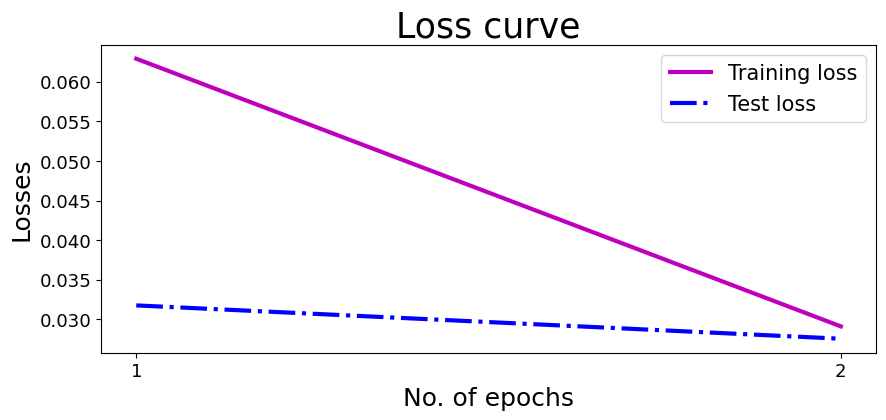

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss, 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)

# Reverse process

In [ ]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)


0it [00:00, ?it/s]

1000it [00:06, 145.41it/s]


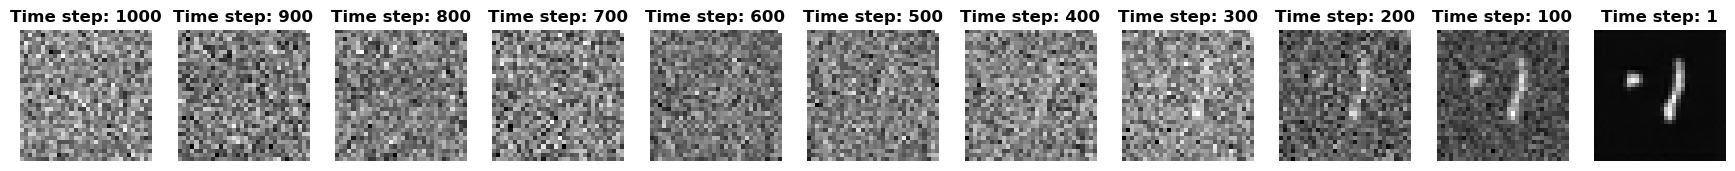

In [ ]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1

# Random sampling from noise

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)



1000it [00:22, 44.62it/s]


(-0.5, 545.5, 137.5, -0.5)

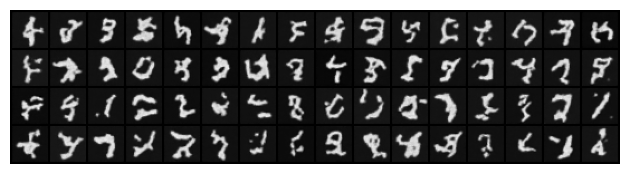

In [ ]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

**TODO**
## EVALUATION

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F



In [ ]:
# Resize images from 32x32 to 28x28 using PyTorch
sampled_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)

# Process resized images
sampled_imgs_np = sampled_imgs_resized.cpu().numpy()  # Convert to NumPy array
sampled_imgs_np = (sampled_imgs_np * 0.5) + 0.5       # Denormalize to [0, 1]
sampled_imgs_np = np.clip(sampled_imgs_np, 0, 1)      # Ensure values are within [0, 1]
sampled_imgs_np = np.transpose(sampled_imgs_np, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)

# Convert to TensorFlow tensor
sampled_imgs_tf = tf.convert_to_tensor(sampled_imgs_np, dtype=tf.float32)


In [ ]:
# Load the pre-trained MNIST classifier
MNIST_MODULE = "https://tfhub.dev/tensorflow/tfgan/eval/mnist/logits/1"
mnist_classifier_fn = tfhub.load(MNIST_MODULE)


# Define the classifier function
def classifier_fn(images):
    outputs = mnist_classifier_fn(images=images)
    return outputs  # Outputs is a tensor of logits

# Function to compute activations
def compute_activations(images, num_batches, classifier_fn):
    images_list = tf.split(images, num_or_size_splits=num_batches)
    activations = []
    for batch in images_list:
        outputs = classifier_fn(images=batch)
        activations.append(outputs)
    activations = tf.concat(activations, axis=0)
    return activations

# Compute activations for real MNIST images
def load_mnist():
    ds = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=transforms.Compose([
            transforms.Resize((28, 28)),  # Ensure images are 28x28
            transforms.ToTensor(),
        ]),
    )
    dl = DataLoader(ds, batch_size=60000, shuffle=False)
    x, _ = next(iter(dl))
    x = x.numpy()  # Convert to NumPy array
    x = np.transpose(x, (0, 2, 3, 1))  # Shape: (N, 28, 28, 1)
    return tf.convert_to_tensor(x, dtype=tf.float32)

mnist_images_tf = load_mnist()
activations_real = compute_activations(
    mnist_images_tf, num_batches=1, classifier_fn=classifier_fn)

# Compute activations for generated images
activations_fake = compute_activations(
    sampled_imgs_tf, num_batches=1, classifier_fn=classifier_fn)

# Compute FID
fid = tfgan.eval.frechet_classifier_distance_from_activations(
    activations_real, activations_fake)

print(f"FID: {fid.numpy()}")


FID: 15.898444175720215
